Gebil Jibul

Description: This program demonstrates the application of hyperparameter tuning to tune a linear regression model for price prediction.

Solutions:

    * regression model that can predict profit
    * Report relevant metrics for this type of model 
        (this is a regression problem so I will use regression evaluation metrics)
    * Hyperparameter tune the model with cross-fold validation 

#### Data

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('data/startup_profit.csv')

# Cleans column names
data.rename(str.strip, axis='columns', inplace=True)
data.rename(str.lower, axis='columns', inplace=True)

# Converts profit column to type float
data['profit'] = data['profit'].replace("[$,]", "", regex=True).astype(float)

#### EDA

In [3]:
data.corr()['profit']

r&d spend          0.972900
administration     0.200717
marketing spend    0.747766
profit             1.000000
Name: profit, dtype: float64

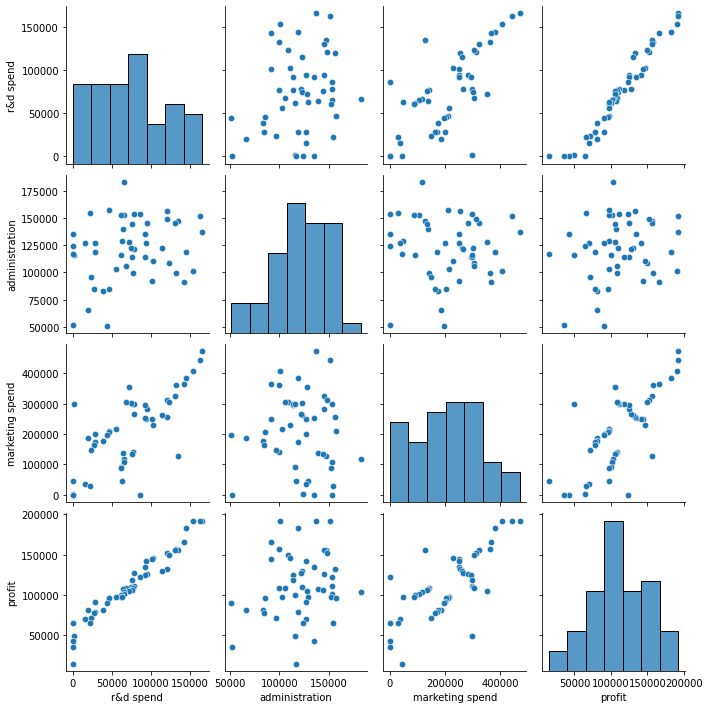

In [4]:
import seaborn as sns

sns.pairplot(data, plot_kws={"s": 40});

#### Train-test split


In [24]:
from sklearn.model_selection import train_test_split

# Holds index of X due to conversion to array
index = ['r&d spend', 'administration', 'marketing spend']

# Seperates input and output
X = data.drop(['profit', 'state'], axis=1)
y = data['profit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

#### Standardization > Training > Predicting (Untuned)

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn import decomposition

# Instance of the standardizer class
std_slc = StandardScaler()

# Instance of Principal Component Analysis(PCA)
pca = decomposition.PCA()

# Instance of the linear regression class
linear_Reg = LinearRegression()

# Pipeline
pipe = Pipeline(steps=[('std_slc', std_slc), ('pca', pca), ('linear_Reg', linear_Reg)])

In [26]:
# Retrieving predictions on train data
pipe.fit(X_train, y_train)
y_train_pred = pipe.predict(X_train)

# Shows coefficients of each variabes
pd.Series(linear_Reg.coef_, index=index).round(2)

r&d spend          27411.79
administration      2239.16
marketing spend   -22856.36
dtype: float64

In [27]:
from sklearn.metrics import mean_absolute_error

y_test_pred = pipe.predict(X_test)

# Evaluates model with mean absolute error
mae = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
print(f'MAE: {mae.round(2)}')

MAE: 7886.93


In [28]:
from sklearn.model_selection import cross_validate

# 10-fold cross validation
cv_results = cross_validate(linear_Reg, X, y, scoring='neg_mean_absolute_error', cv=10)
scores = -1*cv_results['test_score']

# Returns the mean of all 10 MAEs
scores.mean().round(2)

7422.25

#### Standardization > Training > Predicting (Tuned)

In [32]:
pipe.get_params(deep=True).keys()

dict_keys(['memory', 'steps', 'verbose', 'std_slc', 'pca', 'linear_Reg', 'std_slc__copy', 'std_slc__with_mean', 'std_slc__with_std', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'linear_Reg__copy_X', 'linear_Reg__fit_intercept', 'linear_Reg__n_jobs', 'linear_Reg__normalize', 'linear_Reg__positive'])

In [30]:
import numpy as np
from sklearn.model_selection import GridSearchCV

# List of column numbers (n-components) for PCA optimization
n_components = list(range(1, X.shape[1]+1, 1))

# List of linear regression hyperparameters to try
n_jobs = [1, -1]
positive = [True, False]

# Create dict with parameters
parameters = dict(pca__n_components=n_components,
                  linear_Reg__n_jobs=n_jobs,
                  linear_Reg__positive=positive)

# Gridsearch object instantiation and fitting data
clf_GS = GridSearchCV(pipe, parameters)
clf_GS.fit(X, y)

print('Best Of N Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])
print('Best Of N Jobs:', clf_GS.best_estimator_.get_params()['linear_Reg__n_jobs'])
print('Best Of Positive (Bool):', clf_GS.best_estimator_.get_params()['linear_Reg__positive'])
print(); print(clf_GS.best_estimator_.get_params()['linear_Reg'])

Best Of N Components: 3
Best Of N Jobs: 1
Best Of Positive (Bool): False

LinearRegression(n_jobs=1)


In [37]:
# Instantiates each class with best params
std_slc = StandardScaler()
pca = decomposition.PCA(n_components=3)
linear_Reg = LinearRegression(n_jobs=1, positive=False)

# Pipeline
pipe = Pipeline(steps=[('std_slc', std_slc), ('pca', pca), ('linear_Reg', linear_Reg)])

# Retrieving predictions on train data
pipe.fit(X_train, y_train)
y_train_pred = pipe.predict(X_train)

# Shows coefficients of each variabes
pd.Series(linear_Reg.coef_).round(2)

0    27411.79
1     2239.16
2   -22856.36
dtype: float64

In [38]:
y_test_pred = pipe.predict(X_test)

# Evaluates model with mean absolute error
mae = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
print(f'MAE: {mae.round(2)}')

MAE: 7886.93


In [39]:
# 10-fold cross validation
cv_results = cross_validate(linear_Reg, X, y, scoring='neg_mean_absolute_error', cv=10)
scores = -1*cv_results['test_score']

# Returns the mean of all 10 MAEs
scores.mean().round(2)

7422.25